# Численный рассчет температурных волн 
## На основе статьи А. А. Самарского и И. М. Соболя

Рассматривается квазилинейное уравнение теплопроводности

$$\displaystyle \frac{\partial \varphi(u)}{\partial t} = \sum_{\alpha = 1}^p \frac{\partial}{\partial x_\alpha} \left( K_\alpha(u) \frac{\partial u}{\partial x_\alpha}\right),\ K_\alpha(u) = \varkappa_\alpha u^{\sigma_\alpha},\ \sigma_\alpha \geqslant 1,\ \varkappa_\alpha > 0$$

## Одномерный случай $(p = 1)$

Рассмотрим уравнение

$$ \frac{\partial \varphi(u)}{\partial t} = \frac{\partial}{\partial x} \left[K(u) \frac{\partial u}{\partial x}\right]$$

$  K(0) = \varphi(0) = 0 $; $K(u) > 0,\ \varphi^{\prime}(u) > 0$ при $u > 0$; $\displaystyle \lim_{ u \to 0}\left[K(u) /\varphi^{\prime}(u) \right] = 0$

Будем рассматривать задачу с граничными условиями I рода

$$ u(t, 0) = \mu_l(t),\ \ u(t, l) = \mu_r(t) $$

Заменим уравнение однородной разностной схемой с опережением:

$$\varphi(v_i) - \varphi(\check{v_i}) = A_{i+1}(v_{i+1}-v_i) - A_i(v_i - v_{i-1}), \ i=\overline{1, N-1}$$

$$A_i = \frac{\tau}{h^2}K\left(\frac{v_{i-1} + v_i}{2} \right),\ i=\overline{1, N}$$

Символ $\check{v_i}$ — значение сеточной фукнции на шаге $j$ по времени, а $v_i$ — на шаге $j+1$. 

Предполагается равномерная сетка: $x_i = ih,\ 0 \leqslant i \leqslant N; \ t^j = j\tau$.

На каждом шаге по времени будем решать имеющуюся систему уравнений методом итераций. Обозначим номер итерации за $s$:

$$ \varphi \stackrel{(s+1)}{(v_i)} = \varphi \stackrel{(s)}{(v_i)} + \stackrel{(s+1)}{(v_i} - \stackrel{(s)}{v_i})\varphi^\prime \stackrel{(s)}{(v_i)}$$

Далее индексы $(s)$ для краткости опускаются.

$$ A_{i+1} \stackrel{(s+1)}{v_{i+1}} - (A_{i+1} + A_i + B_i)\stackrel{(s+1)}{v_i} + A_i\stackrel{(s+1)}{v_{i-1}} + F_i = 0 $$

$$ B_i = \varphi^\prime(v_i), \ \ F_i = \varphi(\check{v_i}) - \varphi(v_i) + v_iB_i  $$

Воспользуемся методом прогонки:

$$\alpha_1 = 0; \ \ \alpha_{i + 1} = \frac{A_{i+1}}{A_{i+1} + A_i(1-\alpha_i) + B_i}, \ \ i = \overline{1, N-1}$$
$$ \beta_1 = v_0; \ \ \beta_{i+1} = \frac{A_i\beta_i + F_i}{A_{i+1} + A_i(1-\alpha_i) + B_i}, \ \ i = \overline{1,N-1}$$
$$\stackrel{(s+1)}{v_N} = v_N; \ \ \stackrel{(s+1)}{v_i} = \alpha_{i+1}\stackrel{(s+1)}{v_{i+1}} + \beta_{i+1}, \ \ i = \overline{N-1, 1}$$
$$\stackrel{(0)}{v_i} = \check{v_i}, \ \ v_0 = \mu_l(j\tau), \ \ v_N = \mu_r(j\tau)$$

Условие окончания итераций:

$$ \max_{1 \leqslant i \leqslant N-1} \Big| \stackrel{(s+1)}{v_i} - \stackrel{(s)}{v_i} \Big| < \varepsilon $$


Реализуем функцию, делающую один шаг по времени (один проход итерационного метода).

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [60]:
def step_one_dim(u_start, h, tau, K, epsilon = 1e-5, max_iterations=1000):
    '''
    Функция, делающая один шаг по времени (одномерная задача)
    Внутри нет явной зависимости от t, потому что она должна быть включена в u, переданный в функцию 
    Нулевая итерация - это значения с предыдущего шага + граничные условия на новом шаге на слева и справа
    '''
    N = u_start.size - 1 # размер массива x от 0 до Nh включительно N+1
    u_prev = u_start # исходный массив будет изменен!
    u_new = np.zeros_like(u_prev)
    alpha = np.zeros(N)
    beta = np.zeros(N)
    converged = False
    iteration = 0

    while not converged:
        A = tau / h ** 2 * K((u_prev[:-1] + u_prev[1:]) / 2) 
        # тут пока сделан случай phi(u) = u, поэтому B и F имеют очень простой вид
        B = np.ones(N - 1)
        F = u_start[1:-1]
        alpha[0] = 0
        beta[0] = u_prev[0]
        for i in range(0, N - 1): 
            alpha[i + 1] = A[i + 1] / (A[i + 1] + A[i] * (1 - alpha[i]) + B[i])
            beta[i + 1] = (A[i] * beta[i] + F[i]) / (A[i + 1] + A[i] * (1 - alpha[i]) + B[i])
        u_new[-1] = u_prev[-1]
        u_new[0] = u_prev[0]
        for i in range(N - 1, 0, -1):
            u_new[i] = alpha[i] * u_new[i + 1] + beta[i]
        if (np.max(np.abs(u_new - u_prev))) < epsilon:
            converged = True
        u_prev = u_new
        iteration += 1
        if iteration >= max_iterations:
            #print("iteration limit")
            break

    return u_prev

In [57]:
def solve_one_dim(u_start, h, tau, t_end, K, mu_l, mu_r, epsilon=1e-5, max_iterations=10000):
    N_t = int(t_end / tau) #количество шагов по времени (не точек)
    # tau надо округлить так, чтобы достичь t_end
    tau = t_end / N_t
    u = u_start.copy()

    for j in range(1, N_t + 1):
        u[0] = mu_l(j * tau)
        u[-1] = mu_r(j * tau)
        u = step_one_dim(u, h, tau, K, epsilon, max_iterations)

    return u

## Пример 1. Волна, распространяющаяся с постоянной скоростью

Рассмотрим аналитическое решение уравнения

$$ \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}\left(\varkappa_0 u^\sigma \frac{\partial u}{\partial x} \right)$$

Оно представляет собой бегущую волну:

$$ 
u(t, x) = 
 \begin{cases}
   \left[\sigma c \varkappa_0 (ct + x_1 - x) \right]^{1/\sigma} & x \leqslant x_1 + ct\\
   0 & x \geqslant x_1 + ct
 \end{cases} 
$$

 Возьмем $\sigma = 2,\ \varkappa_0 = 0.5,\ c = 5,\ x_1 = 0$

 За начальное условие выберем значение функции при $t_0 = 0.1$

 Краевые условия:  $u(t, 0) = 10 \sqrt{t}, \ \  u(t, x_N) = 0$

In [58]:
kappa_0 = 0.5
sigma = 2
c = 5
x_1 = 0
t_0 = 0.1

def u(x, t):
    return ((sigma * c / kappa_0 * (c * t + x_1 - x)) * np.heaviside(x_1 + c*t - x, 0)) ** (1 / sigma)

# добавим t_0, чтобы за t передавалось относительное время внутри решателя
def mu_l(t):
    return 10 * np.sqrt(t + t_0)

def mu_r(t):
    return 0

def K(u):
    return kappa_0 * u ** sigma

N = 50
x = np.linspace(0, 1, N + 1)
h = 1 / N
tau =  2e-4
max_iter = 10000

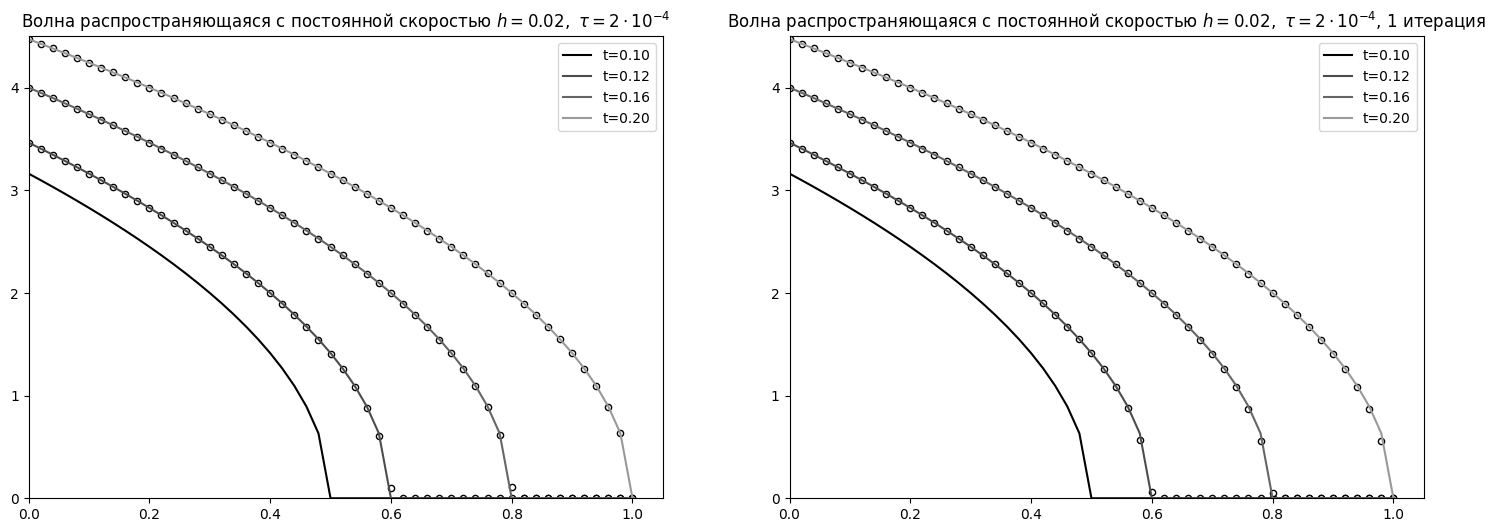

In [66]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(121)
ax1.plot(x, u(x, t_0), color='0', label='t=0.10')
ax1.plot(x, u(x, 0.12), color='0.3', label='t=0.12')
ax1.plot(x, u(x, 0.16), color='0.4', label='t=0.16')
ax1.plot(x, u(x, 0.20), color='0.6', label='t=0.20')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax1.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r, max_iterations=max_iter), c='1', edgecolors='0', s=20)
ax1.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r, max_iterations=max_iter), c='1', edgecolors='0', s=20)
ax1.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.2 - t_0, K, mu_l, mu_r, max_iterations=max_iter), c='1', edgecolors='0', s=20)

ax1.set_ylim(0, 4.5)
ax1.set_yticks(range(0, 5))
ax1.set_xlim(0, 1.05)
ax1.legend()
ax1.set_title("Волна распространяющаяся с постоянной скоростью $h = 0.02, \\ \\tau = 2\\cdot 10^{-4}$")

ax2 = fig.add_subplot(122)
ax2.plot(x, u(x, t_0), color='0', label='t=0.10')
ax2.plot(x, u(x, 0.12), color='0.3', label='t=0.12')
ax2.plot(x, u(x, 0.16), color='0.4', label='t=0.16')
ax2.plot(x, u(x, 0.20), color='0.6', label='t=0.20')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax2.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r, max_iterations=1), c='1', edgecolors='0', s=20)
ax2.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r, max_iterations=1), c='1', edgecolors='0', s=20)
ax2.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.2 - t_0, K, mu_l, mu_r, max_iterations=1), c='1', edgecolors='0', s=20)

ax2.set_ylim(0, 4.5)
ax2.set_yticks(range(0, 5))
ax2.set_xlim(0, 1.05)
ax2.legend()
ax2.set_title("Волна распространяющаяся с постоянной скоростью $h = 0.02, \\ \\tau = 2\\cdot 10^{-4}$, 1 итерация")

plt.show()

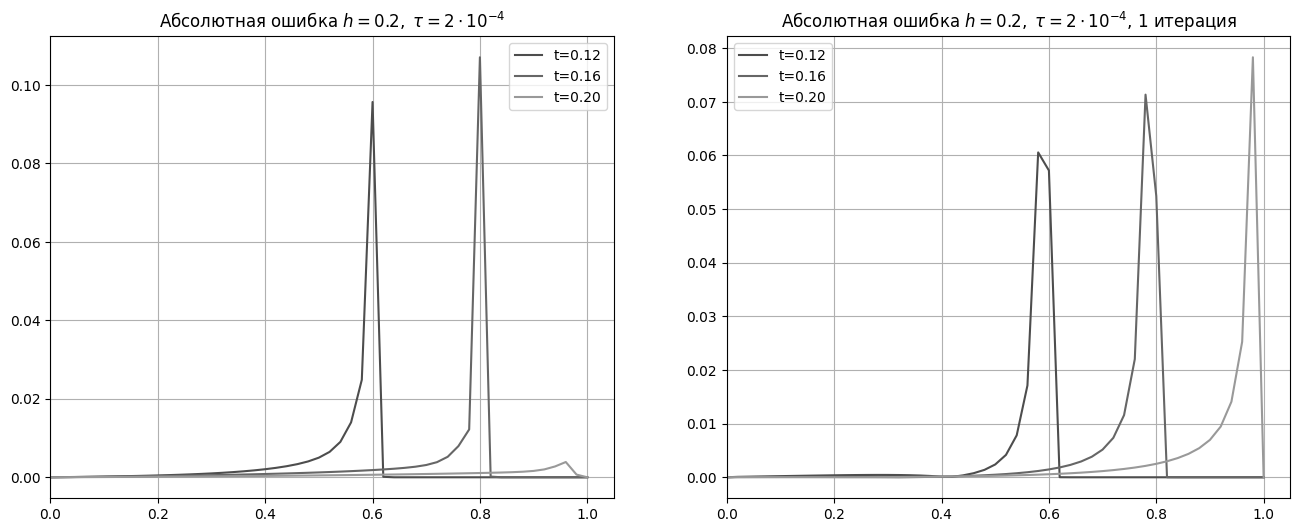

In [70]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax1.plot(x, np.abs(u(x, 0.12) - solve_one_dim(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r, max_iterations=max_iter)), color='0.3', label='t=0.12')
ax1.plot(x, np.abs(u(x, 0.16) - solve_one_dim(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r, max_iterations=max_iter)), color='0.4', label='t=0.16')
ax1.plot(x, np.abs(u(x, 0.20) - solve_one_dim(u(x, t_0), h, tau, 0.20 - t_0, K, mu_l, mu_r, max_iterations=max_iter)), color='0.6', label='t=0.20')

#ax1.set_ylim(0, 0.12)
ax1.set_xlim(0, 1.05)
ax1.legend()
ax1.set_title("Абсолютная ошибка $h = 0.2, \\ \\tau = 2\\cdot 10^{-4}$")
ax1.grid(True)

ax2 = fig.add_subplot(122)

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax2.plot(x, np.abs(u(x, 0.12) - solve_one_dim(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r, max_iterations=1)), color='0.3', label='t=0.12')
ax2.plot(x, np.abs(u(x, 0.16) - solve_one_dim(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r, max_iterations=1)), color='0.4', label='t=0.16')
ax2.plot(x, np.abs(u(x, 0.20) - solve_one_dim(u(x, t_0), h, tau, 0.20 - t_0, K, mu_l, mu_r, max_iterations=1)), color='0.6', label='t=0.20')

#ax2.set_ylim(0, 0.12)
ax2.set_xlim(0, 1.05)
ax2.legend()
ax2.set_title("Абсолютная ошибка $h = 0.2, \\ \\tau = 2\\cdot 10^{-4}$, 1 итерация")
ax2.grid(True)

plt.show()

Попробуем менять h и $\tau$ совместно, так, чтобы $\tau \sim h^2$

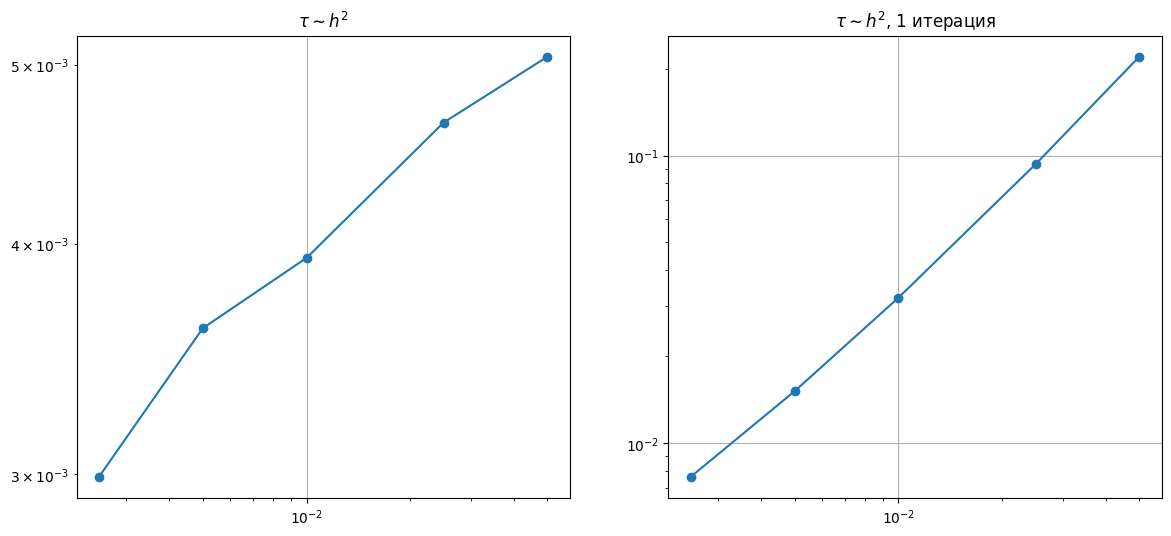

In [39]:
h_steps = np.array([0.05, 0.025, 0.01, 0.005, 0.0025])
err = []
err_1 = []

for h_i in h_steps:
    x_i = np.linspace(0, 1, int(1 / h_i)+1)
    err.append(np.max(np.abs(u(x_i, 0.2) - solve_one_dim(u(x_i, t_0), h_i, 0.45 * h_i**2, 0.2 - t_0, K, mu_l, mu_r, max_iterations=max_iter))))
    err_1.append(np.max(np.abs(u(x_i, 0.2) - solve_one_dim(u(x_i, t_0), h_i, 0.45 * h_i**2, 0.2 - t_0, K, mu_l, mu_r, max_iterations=1))))

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax1.loglog(h_steps, err, marker='o')
ax1.set_title("$\\tau \\sim h^2$")
ax1.grid(True)

ax2 = fig.add_subplot(122)
ax2.loglog(h_steps, err_1, marker='o')
ax2.set_title("$\\tau \\sim h^2$, 1 итерация")
ax2.grid(True)

plt.show()

## Пример 2. Нераспространяющийся фронт

Рассмотрим аналитическое решение уравнения

$$ \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}\left(\varkappa_0 u^\sigma \frac{\partial u}{\partial x} \right), \ -\infty < t < c$$

Его аналитическое решение:

$$ 
u(t, x) = 
 \begin{cases}
   \left[ \frac{\sigma (x_1-x)^2)}{2\varkappa_0 (\sigma+2)(c-t)} \right]^{1/\sigma} & x \leqslant x_1 \\
   0 & x \geqslant x_1 
 \end{cases} 
$$

Возьмем $\sigma = 2,\ \varkappa_0 = 0.5,\ x_1 = 0.5,\ c = 0.1125$

Начальное условие — значение при $t_0 = 0.1$

Краевые условия:  $u(t, 0) = 1 / \sqrt{0.9-8t},\ \ u(t, x_N) = 0$

In [71]:
kappa_0 = 0.5
sigma = 2
c = 0.1125
x_1 = 0.5
t_0 = 0.1

def u(x, t):
    return ((sigma * (x_1 - x) ** 2) / (2 * kappa_0 * (sigma + 2) * (c - t)) * np.heaviside(x_1 - x, 0)) ** (1 / sigma)

# добавим t_0, чтобы за t передавалось относительное время внутри решателя
def mu_l(t):
    return 1 / np.sqrt(0.9 - 8 * (t + t_0))

def mu_r(t):
    return 0

def K(u):
    return kappa_0 * u ** sigma

N = 50
x = np.linspace(0, 1, N + 1)
h = 1 / N
tau =  1e-4
max_iter = 10000

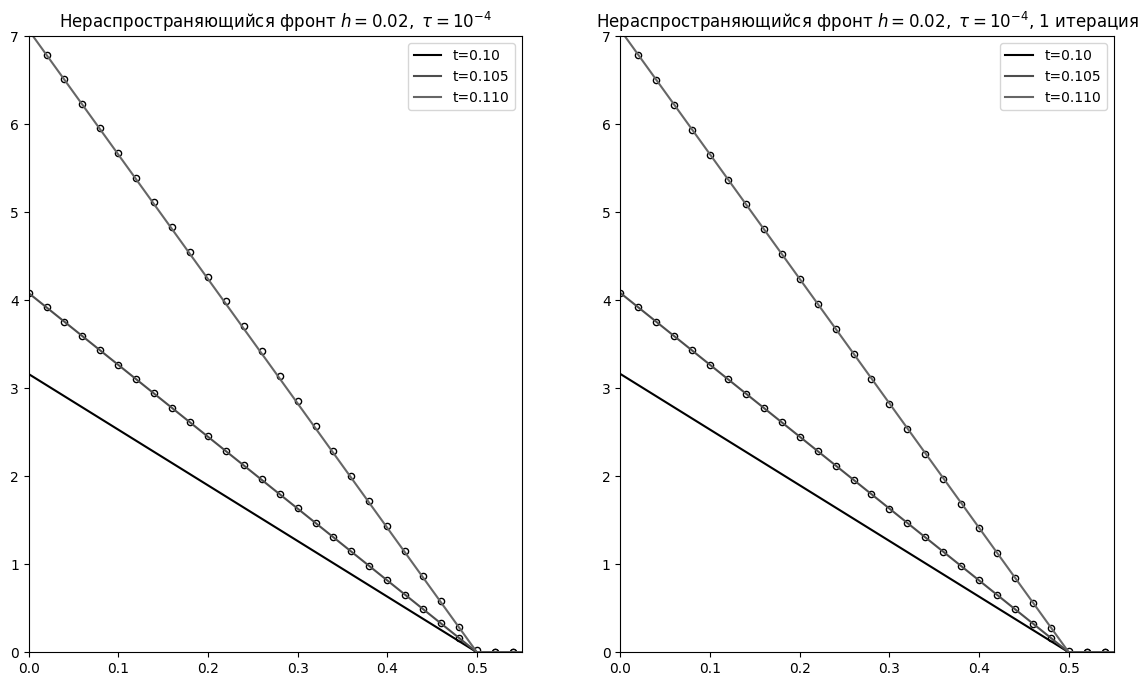

In [72]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(121)
ax1.plot(x, u(x, t_0), color='0', label='t=0.10')
ax1.plot(x, u(x, 0.105), color='0.3', label='t=0.105')
ax1.plot(x, u(x, 0.110), color='0.4', label='t=0.110')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax1.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.105 - t_0, K, mu_l, mu_r, max_iterations=max_iter), c='1', edgecolors='0', s=20)
ax1.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.110 - t_0, K, mu_l, mu_r, max_iterations=max_iter), c='1', edgecolors='0', s=20)

ax1.set_ylim(0, 7)
ax1.set_yticks(range(0, 8))
ax1.set_xlim(0, 0.55)
ax1.legend()
ax1.set_title("Нераспространяющийся фронт $h = 0.02, \\ \\tau = 10^{-4}$")

ax2 = fig.add_subplot(122)
ax2.plot(x, u(x, t_0), color='0', label='t=0.10')
ax2.plot(x, u(x, 0.105), color='0.3', label='t=0.105')
ax2.plot(x, u(x, 0.110), color='0.4', label='t=0.110')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax2.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.105 - t_0, K, mu_l, mu_r, max_iterations=1), c='1', edgecolors='0', s=20)
ax2.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.110 - t_0, K, mu_l, mu_r, max_iterations=1), c='1', edgecolors='0', s=20)

ax2.set_ylim(0, 7)
ax2.set_yticks(range(0, 8))
ax2.set_xlim(0, 0.55)
ax2.legend()
ax2.set_title("Нераспространяющийся фронт $h = 0.02, \\ \\tau = 10^{-4}$, 1 итерация")

plt.show()

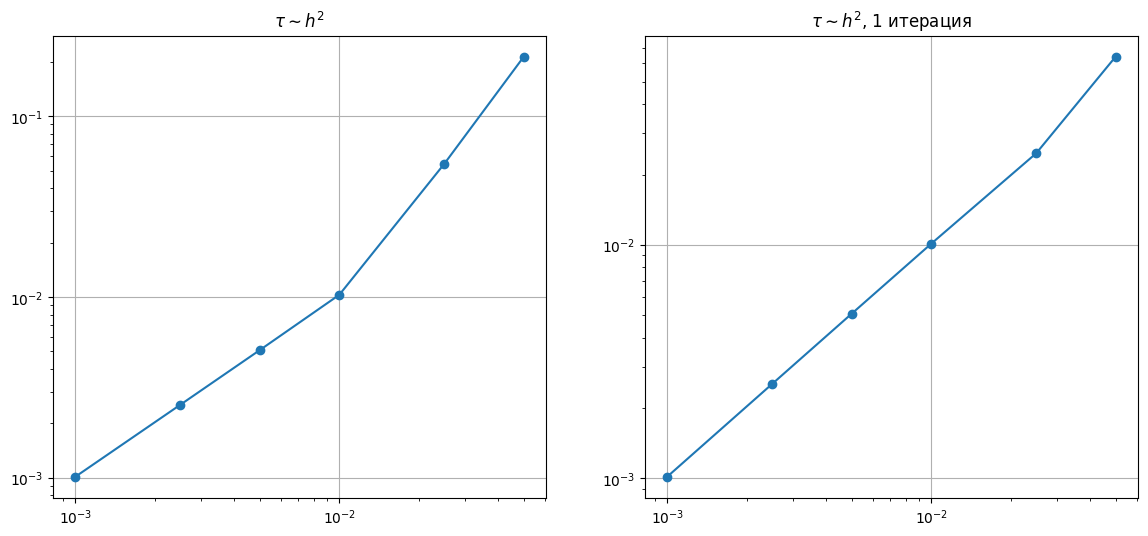

In [73]:
h_steps = np.array([0.05, 0.025, 0.01, 0.005, 0.0025, 0.001])
err = []
err_1 = []

for h_i in h_steps:
    x_i = np.linspace(0, 1, int(1 / h_i)+1)
    err.append(np.max(np.abs(u(x_i, 0.11) - solve_one_dim(u(x_i, t_0), h_i, 0.3 * h_i**2, 0.11 - t_0, K, mu_l, mu_r, max_iterations=max_iter))))
    err_1.append(np.max(np.abs(u(x_i, 0.11) - solve_one_dim(u(x_i, t_0), h_i, 0.3 * h_i**2, 0.11 - t_0, K, mu_l, mu_r, max_iterations=1))))

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax1.loglog(h_steps, err, marker='o')
ax1.set_title("$\\tau \\sim h^2$")
ax1.grid(True)

ax2 = fig.add_subplot(122)
ax2.loglog(h_steps, err_1, marker='o')
ax2.set_title("$\\tau \\sim h^2$, 1 итерация")
ax2.grid(True)

plt.show()

## Двумерный случай (p = 2)

Уравнение принимает вид:

$$\displaystyle \frac{\partial u}{\partial t} = \frac{\partial}{\partial x} \left( K_1(u) \frac{\partial u}{\partial x}\right) + \frac{\partial}{\partial y} \left( K_2(u)\frac{\partial u}{\partial y}\right) $$

Дополним граничными условиями:

$$ u(t, 0, y) = \mu_1^l(t, y), \ \ \ u(t, x, 0) = \mu_2^l(t,x) $$
$$ u(t, l_1, y) = \mu_1^r(t, y), \ \ \ u(t, x, l_2) = \mu_2^r(t, x) $$

Используем равномерную сетку: $x_i = ih_1, \ 0 \leqslant i \leqslant N_1$; $y_k = kh_2, \ 0 \leqslant k \leqslant N_2$; $t^j=j\tau$.

В начальный момент t_0 задана матрица начальных значений $(v_{ik}^0)$.

Переход от $(v_{ik}^j)$ к $(v_{ik}^{j+1})$ (шаг по времени) осуществляется в 2 этапа:

1. Вычисляем матрицу $(v_{ik}^{j+1/2})$ используя одномерную программу для $x$, где $y$ выступает в качестве параметра. Для каждого $k$ мы по строчке $v_{ik}^j$ вычисляем строчку $(v_{ik}^{j+1/2})$

$$ A_i = \tau h_1^{-2} K_1 [0.5(v_{i-1} + v_i)] $$
$$ v_0 = \mu_1^l((j+1/2)\tau, kh_2) $$
$$ v_{N_1} = \mu_1^r((j+1/2)\tau, kh_2)$$


2. Теперь для каждого $i$ мы по столбцу $v_{ik}^{j+1/2}$ вычисляем столбец $v_{ik}^{j+1}$

$$ A_i = \tau h_2^{-2} K_2 [0.5(v_{k-1} + v_k)] $$
$$ v_0 = \mu_2^l((j+1)\tau, ih_1) $$
$$ v_{N_2} = \mu_2^r((j+1)\tau, ih_1)$$

Аналитическое решение уравнения можно искать в виде плоскоской бегущей волны $u = f(\omega)$

$$ \omega = t - \lambda_1 x - \lambda_2 y$$

Подставляя это в уравнение $(K_i(u) = \varkappa_i u^{\sigma_i})$ получим ОДУ, интеграл которого имеет вид

$$ \omega = C_1 + \varkappa_1 \lambda_1^2 \int \frac{u^{\sigma_1} du}{u - C} + \varkappa_2 \lambda_2^2 \int \frac{u^{\sigma_2} du}{u - C} $$

При $C = 0$ получим наиболее простое семейство решений:

$$ \omega = C_1 + (\varkappa_1 / \sigma_1)\lambda_1^2u^{\sigma_1} + (\varkappa_2 / \sigma_2)\lambda_2^2u^{\sigma_2}$$

In [75]:
def solve_two_dim(u_start, h_1, h_2, tau, t_end, K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2, epsilon=1e-5, max_iterations=10000):
    N_t = int(t_end / tau) #количество шагов по времени (не точек)
    # tau надо округлить так, чтобы достичь t_end
    tau = t_end / N_t
    u = u_start.copy() # матрица N2 x N1

    for j in range(0, N_t):
        # меняем строки
        for k in range(1, u.shape[0] - 1):
            u[k, 0] = (mu_l_1((j + 0.5) * tau, k * h_2))[0]
            u[k, -1] = (mu_r_1((j + 0.5) * tau, k * h_2))[0]
            u[k, :] = step_one_dim(u[k, :], h_1, tau, K_1, epsilon, max_iterations)
        # меняем столбцы
        for i in range(1, u.shape[1] - 1):
            u[0, i] = mu_l_2((j + 1) * tau, i * h_1)[0]
            u[-1, i] = mu_r_2((j + 1) * tau, i * h_1)[0]
            u[:, i] = step_one_dim(u[:, i], h_2, tau, K_2, epsilon, max_iterations)

        # проставим граничные условия
        u[0, :] = mu_l_2((j + 1) * tau, [i * h_1 for i in range(u.shape[1])]) # низ
        u[-1, :] = mu_r_2((j + 1) * tau, [i * h_1 for i in range(u.shape[1])]) # верх
        u[:, 0] = mu_l_1((j + 1) * tau, [k * h_2 for k in range(u.shape[0])]) # лево
        u[:, -1] = mu_r_1((j + 1) * tau, [k * h_2 for k in range(u.shape[0])]) # право

    return u

## Пример 5. Анизотропная плоская волна

Рассмотрим двумерное уравнение с параметрами 

$$ \sigma_1 = 4,\ \varkappa_1 = 4;\ \ \ \sigma_2 = 2,\ \varkappa_2 = 0.25 $$

Используем решение с заданными постоянными $C = 0,\ C_1 = 0,\ \lambda_1 = 1,\ \lambda_2 = 2$

$$ 
u(t, x, y) = 
 \begin{cases}
   0.5\sqrt{-1+\sqrt{1+16(t-x-2y)}} & t \geqslant x + 2y\\
   0 & t \leqslant x + 2y
 \end{cases} 
$$

Из него получим начальные и краевые условия. 

Задача решается в прямоугольнике $[0, 30] \times [0, 20]$.

In [76]:
sigma_1 = 4
kappa_1 = 4
sigma_2 = 2
kappa_2 = 0.25
lambda_1 = 1
lambda_2 = 2
l_1 = 30
l_2 = 20

def u(t, x, y):
    X, Y = np.meshgrid(x, y)
    u = np.zeros_like(X, dtype=float)
    mask = t > X + 2 * Y
    u[mask] = 0.5 * np.sqrt(-1 + np.sqrt(1 + 16 * (t - X[mask] - 2 * Y[mask])))
    return u

def mu_l_1(t, y):
    return u(t, 0, y)[:, 0]

def mu_r_1(t, y):
    return u(t, l_1, y)[:, 0]

def mu_l_2(t, x):
    return u(t, x, 0)[0, :]

def mu_r_2(t, x):
    return u(t, x, l_2)[0, :]

def K_1(u):
    return kappa_1 * u ** sigma_1

def K_2(u):
    return kappa_2 * u ** sigma_2

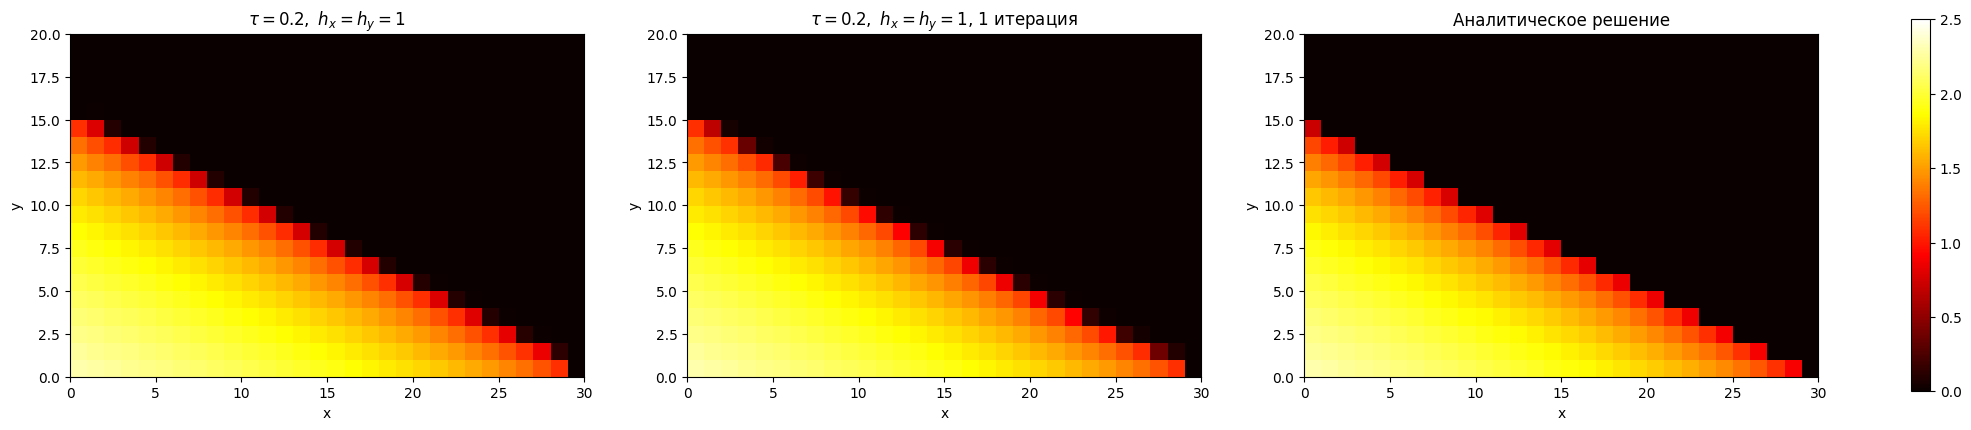

In [82]:
N_1 = 30
N_2 = 20
x = np.linspace(0, l_1, N_1)
y = np.linspace(0, l_2, N_2)
h_1 = l_1 / N_1
h_2 = l_2 / N_2
tau = 0.2
t_end = 30
max_iter = 10000

fig, axes = plt.subplots(1, 3, figsize=(24, 12))
im1 = axes[0].imshow(solve_two_dim(u(0, x, y), h_1, h_2, tau, t_end,\
                               K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2,\
                           1e-6, max_iter),\
                     cmap='hot', origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=2.5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title("$\\tau = 0.2,\\ h_x = h_y = 1$")

im2 = axes[1].imshow(solve_two_dim(u(0, x, y), h_1, h_2, tau, t_end,\
                               K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2,\
                           1e-6, 1),\
                     cmap='hot', origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=2.5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title("$\\tau = 0.2,\\ h_x = h_y = 1$, 1 итерация")

im3 = axes[2].imshow(u(t_end, np.linspace(0, l_1, N_1), np.linspace(0, l_2, N_2)), \
           cmap='hot', origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=2.5)
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title("Аналитическое решение")

fig.colorbar(im1, ax = axes, fraction = 0.01)

plt.show()

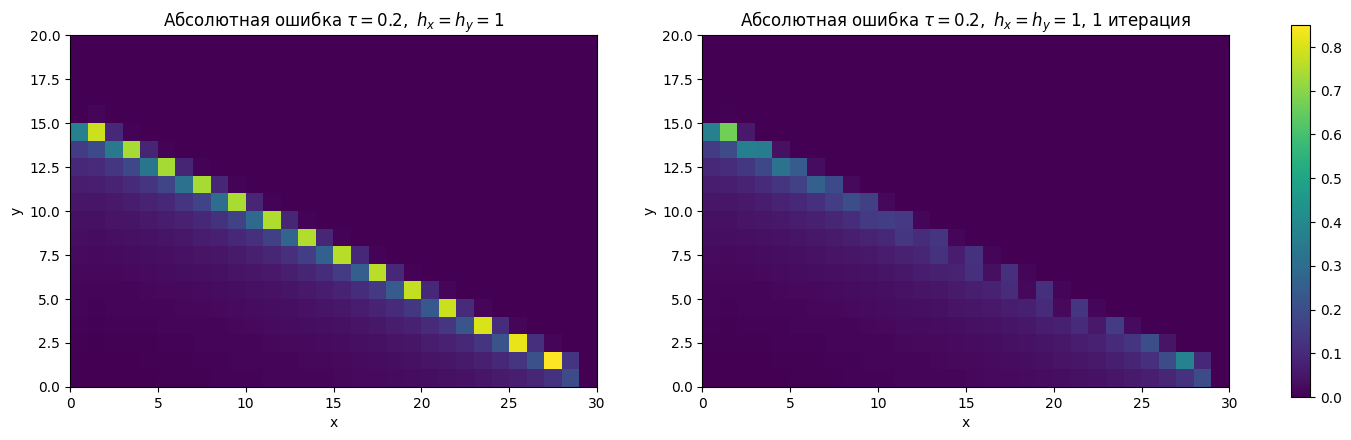

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
im1 = axes[0].imshow(np.abs(u(t_end, np.linspace(0, l_1, N_1), np.linspace(0, l_2, N_2)) - \
                            solve_two_dim(u(0, x, y), h_1, h_2, tau, t_end,\
                               K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2,\
                           1e-6, max_iter)),\
                     origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=0.85)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title("Абсолютная ошибка $\\tau = 0.2,\\ h_x = h_y = 1$")

im2 = axes[1].imshow(np.abs(u(t_end, np.linspace(0, l_1, N_1), np.linspace(0, l_2, N_2)) - \
                            solve_two_dim(u(0, x, y), h_1, h_2, tau, t_end,\
                               K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2,\
                           1e-6, 1)),\
                     origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=0.85)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title("Абсолютная ошибка $\\tau = 0.2,\\ h_x = h_y = 1$, 1 итерация")

fig.colorbar(im1, ax = axes, fraction = 0.015)

plt.show()

In [98]:
N_1 = 100
N_2 = 100
x = np.linspace(0, l_1, N_1)
y = np.linspace(0, l_2, N_2)
h_1 = l_1 / N_1
h_2 = l_2 / N_2
tau = 0.1
t_end = 30

u_analyt = u(t_end, np.linspace(0, l_1, N_1), np.linspace(0, l_2, N_2))
u_num = solve_two_dim(u(0, x, y), h_1, h_2, tau, t_end,\
                               K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2,\
                           1e-6, max_iter)
u_num1 = solve_two_dim(u(0, x, y), h_1, h_2, tau, t_end,\
                               K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2,\
                           1e-6, 1)

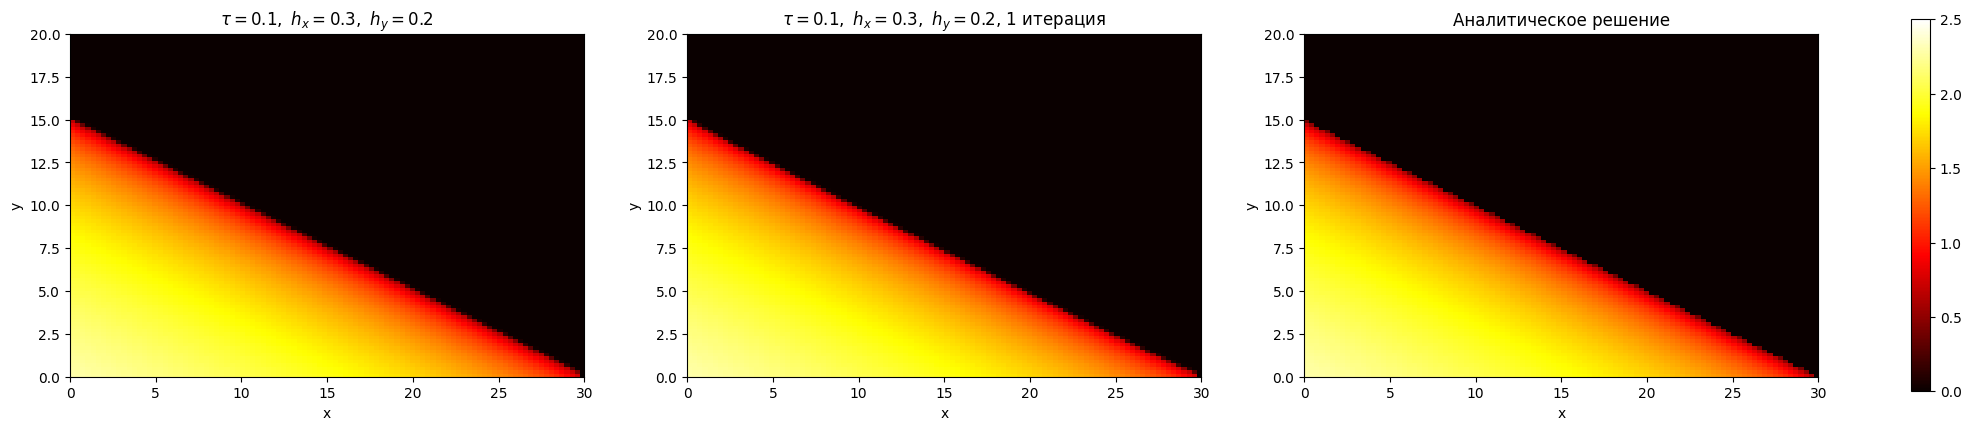

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
im1 = axes[0].imshow(u_num, cmap='hot', origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=2.5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title("$\\tau = 0.1,\\ h_x = 0.3,\\ h_y = 0.2$")

im2 = axes[1].imshow(u_num1, cmap='hot', origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=2.5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title("$\\tau = 0.1,\\ h_x = 0.3,\\ h_y = 0.2$, 1 итерация")

im3 = axes[2].imshow(u_analyt, \
           cmap='hot', origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=2.5)
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title("Аналитическое решение")

fig.colorbar(im1, ax = axes, fraction = 0.01)

plt.show()

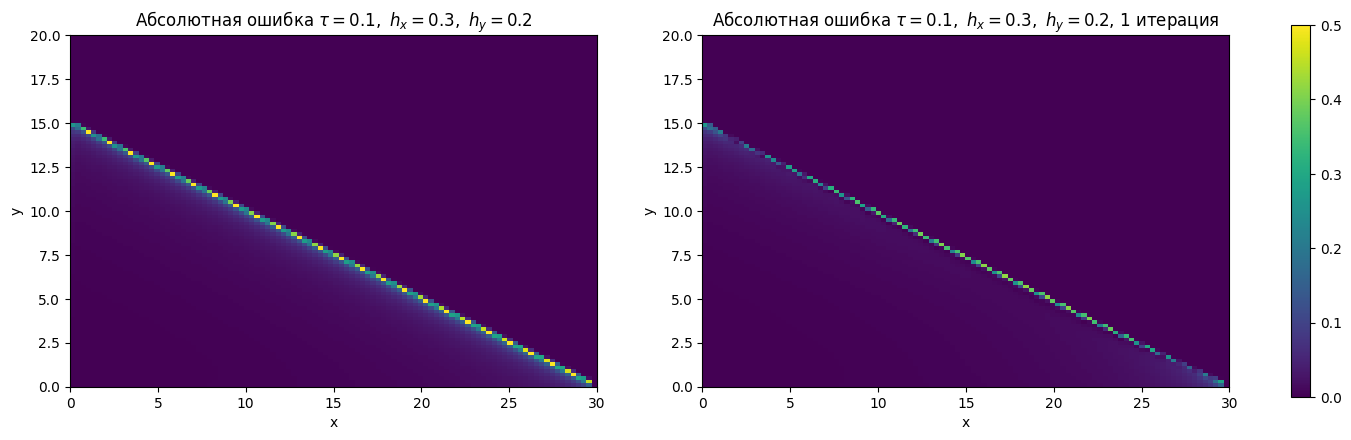

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
im1 = axes[0].imshow(np.abs(u_analyt - u_num), origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=0.5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title("Абсолютная ошибка $\\tau = 0.1,\\ h_x = 0.3,\\ h_y = 0.2$")

im2 = axes[1].imshow(np.abs(u_analyt - u_num1), origin='lower', extent=(0, l_1, 0, l_2), vmin=0, vmax=0.5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title("Абсолютная ошибка $\\tau = 0.1,\\ h_x = 0.3,\\ h_y = 0.2$, 1 итерация")

fig.colorbar(im2, ax = axes, fraction = 0.015)

plt.show()

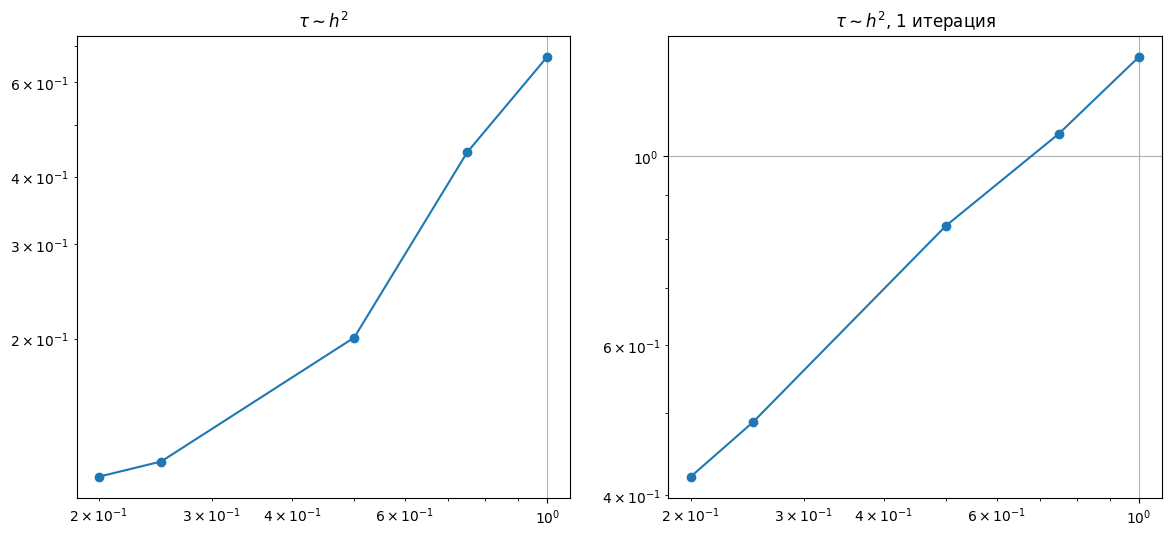

In [106]:
h_steps = np.array([1, 0.75, 0.5, 0.25, 0.2])
err = []
err_1 = []

for h_i in h_steps:
    x_i = np.linspace(0, l_1, int(l_1 / h_i)+1)
    y_i = np.linspace(0, l_2, int(l_2 / h_i)+1)
    err.append(np.max(np.abs(u(t_end, x_i, y_i) - solve_two_dim(u(0, x_i, y_i), h_i, h_i, h_i ** 2, t_end, K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2, max_iterations=max_iter))))
    err_1.append(np.max(np.abs(u(t_end, x_i, y_i) - solve_two_dim(u(0, x_i, y_i), h_i, h_i, h_i ** 2, t_end, K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2, max_iterations=1))))

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax1.loglog(h_steps, err, marker='o')
ax1.set_title("$\\tau \\sim h^2$")
ax1.grid(True)

ax2 = fig.add_subplot(122)
ax2.loglog(h_steps, err_1, marker='o')
ax2.set_title("$\\tau \\sim h^2$, 1 итерация")
ax2.grid(True)

plt.show()

## Явная схема

In [129]:
kappa_0 = 0.5
sigma = 2
c = 5
x_1 = 0
t_0 = 0.1

def u(x, t):
    return ((sigma * c / kappa_0 * (c * t + x_1 - x)) * np.heaviside(x_1 + c*t - x, 0)) ** (1 / sigma)

# добавим t_0, чтобы за t передавалось относительное время внутри решателя
def mu_l(t):
    return 10 * np.sqrt(t + t_0)

def mu_r(t):
    return 0

def K(u):
    return kappa_0 * u ** sigma

N = 50
x = np.linspace(0, 1, N + 1)
h = 1 / N
tau =  1e-5
max_iter = 10000

from IPython.display import clear_output

def step_one_dim_explisit(u_start, h, tau, K):
    '''
    Функция, делающая один шаг по времени (одномерная задача)
    Внутри нет явной зависимости от t, потому что она должна быть включена в u, переданный в функцию 
    Нулевая итерация - это значения с предыдущего шага + граничные условия на новом шаге на слева и справа
    '''
    N = u_start.size - 1 # размер массива x от 0 до Nh включительно N+1
    u_prev = u_start # исходный массив будет изменен!
    u_new = np.zeros_like(u_prev)
    A = tau / h ** 2 * K((u_prev[:-1] + u_prev[1:]) / 2) 
    u_new[-1] = u_prev[-1]
    u_new[0] = u_prev[0]

    u_new[1:-1] = A[1:] * (u_prev[2:] - u_prev[1:-1]) - A[:-1] * (u_prev[1:-1] - u_prev[:-2]) + u_prev[1:-1]
    # for i in range(1, N):
    #     u_new[i] = A[i] * (u_prev[i + 1] - u_prev[i]) - A[i - 1] * (u_prev[i] - u_prev[i - 1]) + u_prev[i]

    return u_new

def solve_one_dim_explisit_plot(u_start, h, tau, t_end, K, mu_l, mu_r):
    N_t = int(t_end / tau) #количество шагов по времени (не точек)
    # tau надо округлить так, чтобы достичь t_end
    tau = t_end / N_t
    u = u_start.copy()

    for j in range(1, N_t + 1):
        u[0] = mu_l(j * tau)
        u[-1] = mu_r(j * tau)
        u = step_one_dim_explisit(u, h, tau, K)
        if (j % 100 == 0):
            clear_output(True)
            plt.plot(x, u, color='black')
            plt.title(f"Явная схема t = {t_0 + j * tau:.3f}")
            plt.grid(True)
            plt.show()

def solve_one_dim_explisit(u_start, h, tau, t_end, K, mu_l, mu_r):
    N_t = int(t_end / tau) #количество шагов по времени (не точек)
    # tau надо округлить так, чтобы достичь t_end
    tau = t_end / N_t
    u = u_start.copy()

    for j in range(1, N_t + 1):
        u[0] = mu_l(j * tau)
        u[-1] = mu_r(j * tau)
        u = step_one_dim_explisit(u, h, tau, K)

    return u

def solve_one_dim_plot(u_start, h, tau, t_end, K, mu_l, mu_r, epsilon=1e-5, max_iterations=10000):
    N_t = int(t_end / tau) #количество шагов по времени (не точек)
    # tau надо округлить так, чтобы достичь t_end
    tau = t_end / N_t
    u = u_start.copy()

    for j in range(1, N_t + 1):
        u[0] = mu_l(j * tau)
        u[-1] = mu_r(j * tau)
        u = step_one_dim(u, h, tau, K, epsilon, max_iterations)
        if (j % 100 == 0):
            clear_output(True)
            plt.plot(x, u, color='black')
            plt.title(f"Неявная схема t = {t_0 + j * tau:.3f}, ограничение {max_iterations} итараций")
            plt.grid(True)
            plt.show()

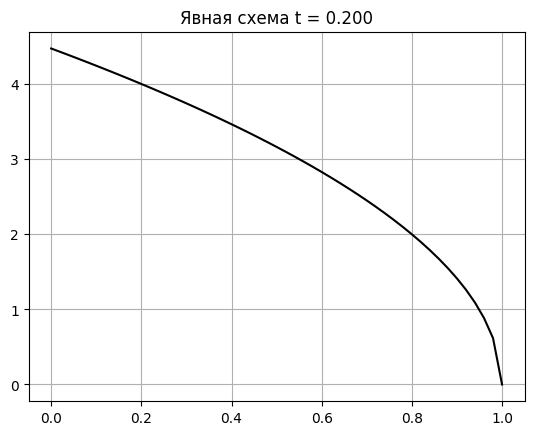

In [117]:
solve_one_dim_explisit_plot(u(x, t_0), h, tau, 0.2 - t_0, K, mu_l, mu_r)

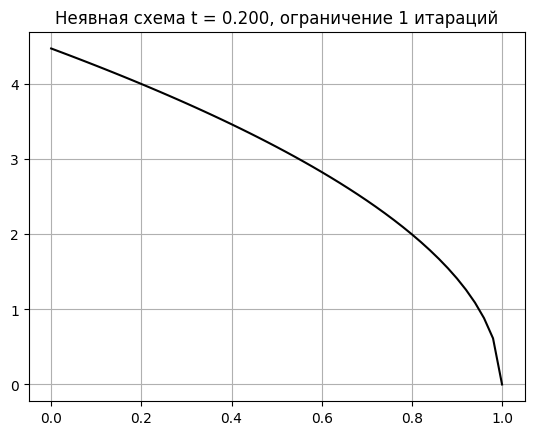

In [122]:
solve_one_dim_plot(u(x, t_0), h, tau, 0.2 - t_0, K, mu_l, mu_r, max_iterations=1)

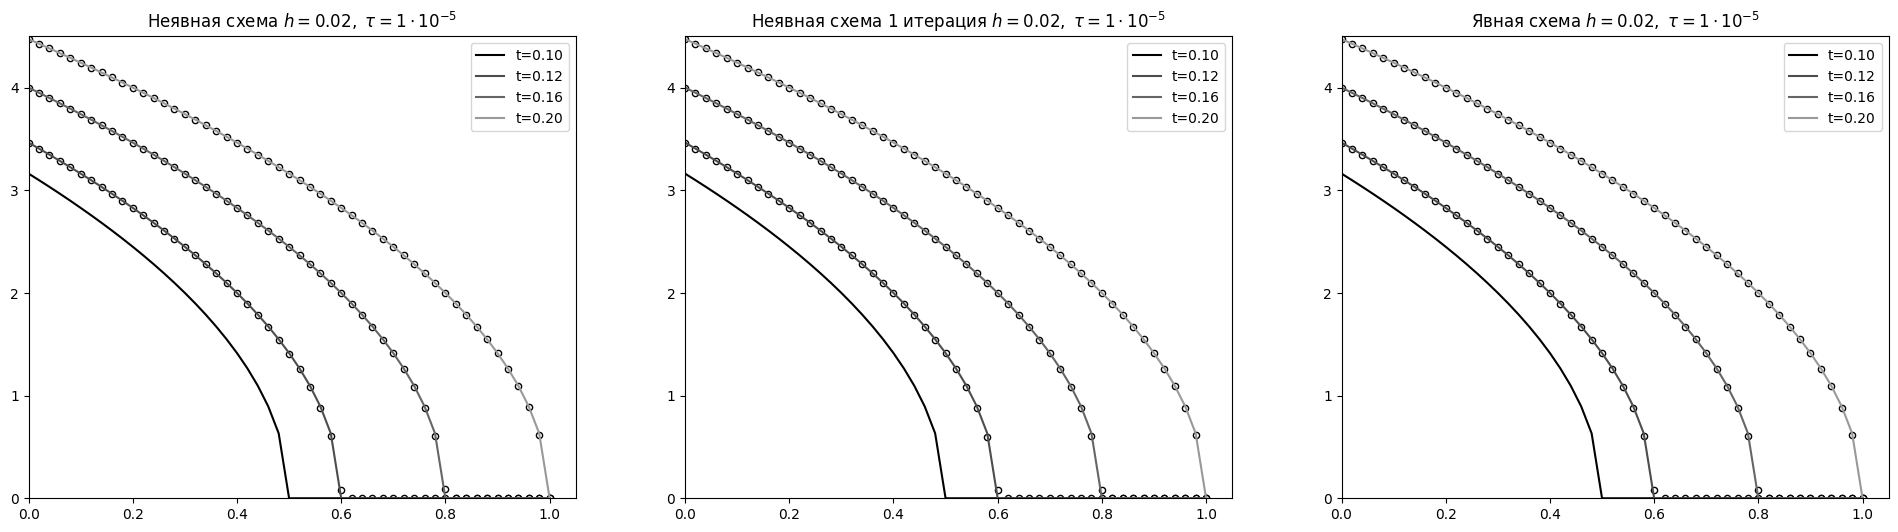

In [130]:
fig = plt.figure(figsize=(24, 6))
ax1 = fig.add_subplot(131)
ax1.plot(x, u(x, t_0), color='0', label='t=0.10')
ax1.plot(x, u(x, 0.12), color='0.3', label='t=0.12')
ax1.plot(x, u(x, 0.16), color='0.4', label='t=0.16')
ax1.plot(x, u(x, 0.20), color='0.6', label='t=0.20')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax1.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r, max_iterations=max_iter), c='1', edgecolors='0', s=20)
ax1.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r, max_iterations=max_iter), c='1', edgecolors='0', s=20)
ax1.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.2 - t_0, K, mu_l, mu_r, max_iterations=max_iter), c='1', edgecolors='0', s=20)

ax1.set_ylim(0, 4.5)
ax1.set_yticks(range(0, 5))
ax1.set_xlim(0, 1.05)
ax1.legend()
ax1.set_title("Неявная схема $h = 0.02, \\ \\tau = 1\\cdot 10^{-5}$")

ax2 = fig.add_subplot(132)
ax2.plot(x, u(x, t_0), color='0', label='t=0.10')
ax2.plot(x, u(x, 0.12), color='0.3', label='t=0.12')
ax2.plot(x, u(x, 0.16), color='0.4', label='t=0.16')
ax2.plot(x, u(x, 0.20), color='0.6', label='t=0.20')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax2.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r, max_iterations=1), c='1', edgecolors='0', s=20)
ax2.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r, max_iterations=1), c='1', edgecolors='0', s=20)
ax2.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.2 - t_0, K, mu_l, mu_r, max_iterations=1), c='1', edgecolors='0', s=20)

ax2.set_ylim(0, 4.5)
ax2.set_yticks(range(0, 5))
ax2.set_xlim(0, 1.05)
ax2.legend()
ax2.set_title("Неявная схема 1 итерация $h = 0.02, \\ \\tau = 1\\cdot 10^{-5}$")

ax3 = fig.add_subplot(133)
ax3.plot(x, u(x, t_0), color='0', label='t=0.10')
ax3.plot(x, u(x, 0.12), color='0.3', label='t=0.12')
ax3.plot(x, u(x, 0.16), color='0.4', label='t=0.16')
ax3.plot(x, u(x, 0.20), color='0.6', label='t=0.20')

ax3.scatter(x, solve_one_dim_explisit(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r), c='1', edgecolors='0', s=20)
ax3.scatter(x, solve_one_dim_explisit(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r), c='1', edgecolors='0', s=20)
ax3.scatter(x, solve_one_dim_explisit(u(x, t_0), h, tau, 0.2 - t_0, K, mu_l, mu_r), c='1', edgecolors='0', s=20)

ax3.set_ylim(0, 4.5)
ax3.set_yticks(range(0, 5))
ax3.set_xlim(0, 1.05)
ax3.legend()
ax3.set_title("Явная схема $h = 0.02, \\ \\tau = 1\\cdot 10^{-5}$")

plt.show()

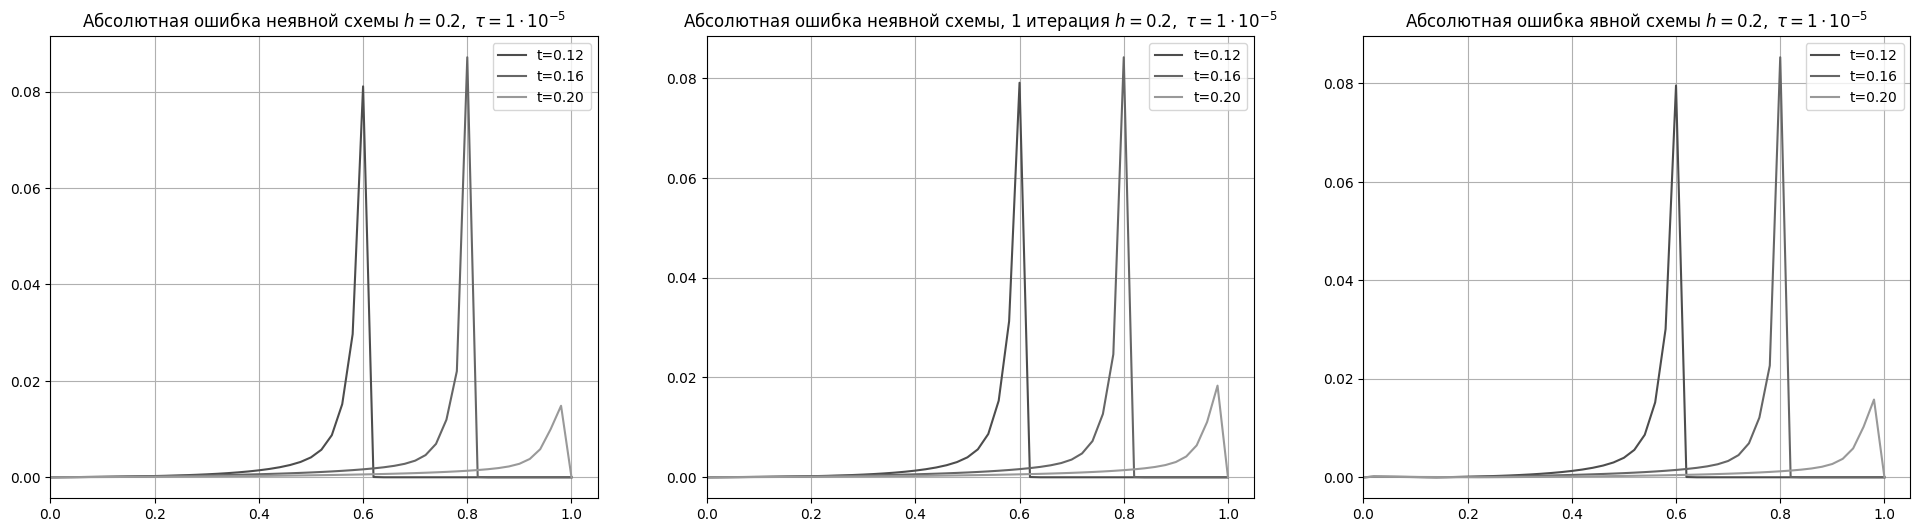

In [131]:
fig = plt.figure(figsize=(24, 6))
ax1 = fig.add_subplot(131)

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax1.plot(x, np.abs(u(x, 0.12) - solve_one_dim(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r, max_iterations=max_iter)), color='0.3', label='t=0.12')
ax1.plot(x, np.abs(u(x, 0.16) - solve_one_dim(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r, max_iterations=max_iter)), color='0.4', label='t=0.16')
ax1.plot(x, np.abs(u(x, 0.20) - solve_one_dim(u(x, t_0), h, tau, 0.20 - t_0, K, mu_l, mu_r, max_iterations=max_iter)), color='0.6', label='t=0.20')

#ax1.set_ylim(0, 0.12)
ax1.set_xlim(0, 1.05)
ax1.legend()
ax1.set_title("Абсолютная ошибка неявной схемы $h = 0.2, \\ \\tau = 1\\cdot 10^{-5}$")
ax1.grid(True)

ax2 = fig.add_subplot(132)

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax2.plot(x, np.abs(u(x, 0.12) - solve_one_dim(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r, max_iterations=1)), color='0.3', label='t=0.12')
ax2.plot(x, np.abs(u(x, 0.16) - solve_one_dim(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r, max_iterations=1)), color='0.4', label='t=0.16')
ax2.plot(x, np.abs(u(x, 0.20) - solve_one_dim(u(x, t_0), h, tau, 0.20 - t_0, K, mu_l, mu_r, max_iterations=1)), color='0.6', label='t=0.20')

#ax2.set_ylim(0, 0.12)
ax2.set_xlim(0, 1.05)
ax2.legend()
ax2.set_title("Абсолютная ошибка неявной схемы, 1 итерация $h = 0.2, \\ \\tau = 1\\cdot 10^{-5}$")
ax2.grid(True)

ax3 = fig.add_subplot(133)
ax3.plot(x, np.abs(u(x, 0.12) - solve_one_dim_explisit(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r)), color='0.3', label='t=0.12')
ax3.plot(x, np.abs(u(x, 0.16) - solve_one_dim_explisit(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r)), color='0.4', label='t=0.16')
ax3.plot(x, np.abs(u(x, 0.20) - solve_one_dim_explisit(u(x, t_0), h, tau, 0.20 - t_0, K, mu_l, mu_r)), color='0.6', label='t=0.20')

#ax2.set_ylim(0, 0.12)
ax3.set_xlim(0, 1.05)
ax3.legend()
ax3.set_title("Абсолютная ошибка явной схемы $h = 0.2, \\ \\tau = 1\\cdot 10^{-5}$")
ax3.grid(True)

plt.show()

[0.015788641178887897, 0.015703444599773797, 0.01566099360228168, 0.015635569970158913, 0.015620332666152814]


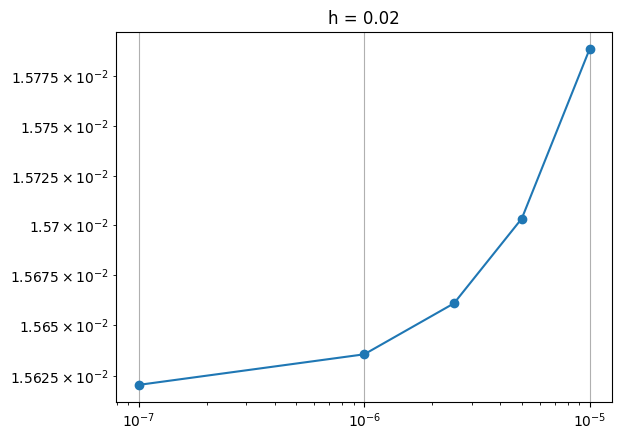

In [181]:
tau_steps = np.array([0.00001, 0.000005, 0.0000025, 0.000001, 1e-7])
h_tau_test = 0.02
x_tau_test = np.linspace(0, 1, int(1 / h_tau_test)+1)
err = []

for tau_i in tau_steps:
    err.append(np.max(np.abs(u(x_tau_test, 0.2) - solve_one_dim_explisit(u(x_tau_test, t_0), h_tau_test, tau_i, 0.2 - t_0, K, mu_l, mu_r))))

print(err)
plt.loglog(tau_steps, err, marker='o')
plt.title(f"h = {h_tau_test}")
plt.grid(True)
plt.show()

[0.03094656645409044, 0.018489505781200566, 0.009775658496130268, 0.006245434383467585, 0.0040919997857440105, 0.002411765668581145]


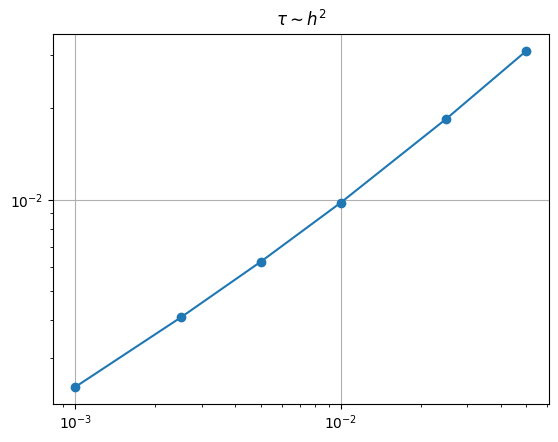

In [191]:
h_steps = np.array([0.05, 0.025, 0.01, 0.005, 0.0025, 0.001])
err = []

for h_i in h_steps:
    x_i = np.linspace(0, 1, int(1 / h_i)+1)
    err.append(np.max(np.abs(u(x_i, 0.2) - solve_one_dim_explisit(u(x_i, t_0), h_i, 0.02 * h_i**2, 0.2 - t_0, K, mu_l, mu_r))))

print(err)
plt.loglog(h_steps, err, marker='o')
plt.title("$\\tau \\sim h^2$")
plt.grid(True)
plt.show()

In [137]:
def solve_two_dim_explisit(u_start, h_1, h_2, tau, t_end, K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2):
    N_t = int(t_end / tau) #количество шагов по времени (не точек)
    # tau надо округлить так, чтобы достичь t_end
    tau = t_end / N_t
    u = u_start.copy() # матрица N2 x N1

    for j in range(0, N_t):
        # меняем строки
        for k in range(1, u.shape[0] - 1):
            u[k, 0] = (mu_l_1((j + 0.5) * tau, k * h_2))[0]
            u[k, -1] = (mu_r_1((j + 0.5) * tau, k * h_2))[0]
            u[k, :] = step_one_dim_explisit(u[k, :], h_1, tau, K_1)
        # меняем столбцы
        for i in range(1, u.shape[1] - 1):
            u[0, i] = mu_l_2((j + 1) * tau, i * h_1)[0]
            u[-1, i] = mu_r_2((j + 1) * tau, i * h_1)[0]
            u[:, i] = step_one_dim_explisit(u[:, i], h_2, tau, K_2)

        # проставим граничные условия
        u[0, :] = mu_l_2((j + 1) * tau, [i * h_1 for i in range(u.shape[1])]) # низ
        u[-1, :] = mu_r_2((j + 1) * tau, [i * h_1 for i in range(u.shape[1])]) # верх
        u[:, 0] = mu_l_1((j + 1) * tau, [k * h_2 for k in range(u.shape[0])]) # лево
        u[:, -1] = mu_r_1((j + 1) * tau, [k * h_2 for k in range(u.shape[0])]) # право

    return u

def solve_two_dim_explisit_plot(u_start, h_1, h_2, tau, t_end, K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2):
    N_t = int(t_end / tau) #количество шагов по времени (не точек)
    # tau надо округлить так, чтобы достичь t_end
    tau = t_end / N_t
    u = u_start.copy() # матрица N2 x N1

    for j in range(0, N_t):
        # меняем строки
        for k in range(1, u.shape[0] - 1):
            u[k, 0] = (mu_l_1((j + 0.5) * tau, k * h_2))[0]
            u[k, -1] = (mu_r_1((j + 0.5) * tau, k * h_2))[0]
            u[k, :] = step_one_dim_explisit(u[k, :], h_1, tau, K_1)
        # меняем столбцы
        for i in range(1, u.shape[1] - 1):
            u[0, i] = mu_l_2((j + 1) * tau, i * h_1)[0]
            u[-1, i] = mu_r_2((j + 1) * tau, i * h_1)[0]
            u[:, i] = step_one_dim_explisit(u[:, i], h_2, tau, K_2)

        # проставим граничные условия
        u[0, :] = mu_l_2((j + 1) * tau, [i * h_1 for i in range(u.shape[1])]) # низ
        u[-1, :] = mu_r_2((j + 1) * tau, [i * h_1 for i in range(u.shape[1])]) # верх
        u[:, 0] = mu_l_1((j + 1) * tau, [k * h_2 for k in range(u.shape[0])]) # лево
        u[:, -1] = mu_r_1((j + 1) * tau, [k * h_2 for k in range(u.shape[0])]) # право

        if (j % 500 == 0):
            clear_output(True)
            plt.imshow(u, cmap='hot', origin='lower', extent=(0, l_1, 0, l_2))
            plt.title(f"Явная схема t={tau * j}")
            plt.show()
            

In [138]:
sigma_1 = 4
kappa_1 = 4
sigma_2 = 2
kappa_2 = 0.25
lambda_1 = 1
lambda_2 = 2
l_1 = 30
l_2 = 20

def u(t, x, y):
    X, Y = np.meshgrid(x, y)
    u = np.zeros_like(X, dtype=float)
    mask = t > X + 2 * Y
    u[mask] = 0.5 * np.sqrt(-1 + np.sqrt(1 + 16 * (t - X[mask] - 2 * Y[mask])))
    return u

def mu_l_1(t, y):
    return u(t, 0, y)[:, 0]

def mu_r_1(t, y):
    return u(t, l_1, y)[:, 0]

def mu_l_2(t, x):
    return u(t, x, 0)[0, :]

def mu_r_2(t, x):
    return u(t, x, l_2)[0, :]

def K_1(u):
    return kappa_1 * u ** sigma_1

def K_2(u):
    return kappa_2 * u ** sigma_2

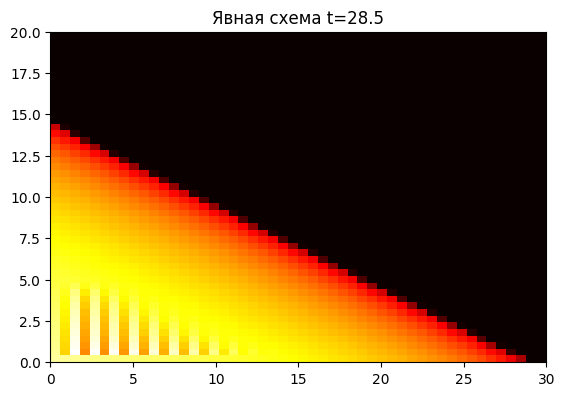

In [140]:
N_1 = 50
N_2 = 50
x = np.linspace(0, l_1, N_1)
y = np.linspace(0, l_2, N_2)
h_1 = l_1 / N_1
h_2 = l_2 / N_2
tau = 3e-3
t_end = 30

solve_two_dim_explisit_plot(u(0, x, y), h_1, h_2, tau, t_end,\
                               K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2)

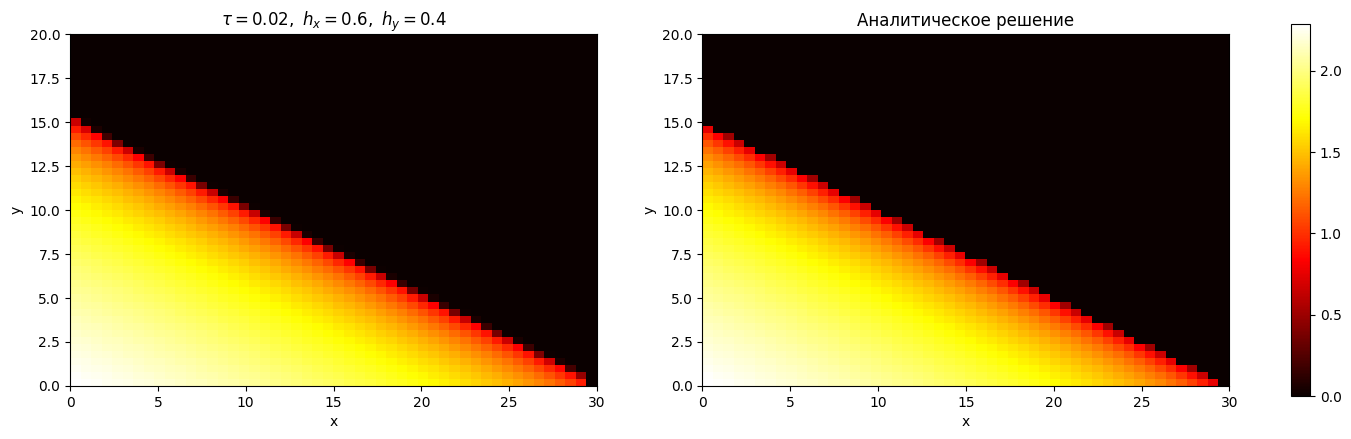

In [207]:
N_1 = 50
N_2 = 50
x = np.linspace(0, l_1, N_1)
y = np.linspace(0, l_2, N_2)
h_1 = l_1 / N_1
h_2 = l_2 / N_2
tau = 1e-3
t_end = 30

fig, axes = plt.subplots(1, 2, figsize=(16, 12))
im1 = axes[0].imshow(solve_two_dim_explisit(u(0, x, y), h_1, h_2, tau, t_end,\
                               K_1, K_2, mu_l_1, mu_l_2, mu_r_1, mu_r_2),\
                     cmap='hot', origin='lower', extent=(0, l_1, 0, l_2))
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title("$\\tau = 1e-3,\\ h_x = 0.6,\\ h_y = 0.4$")

im2 = axes[1].imshow(u(t_end, np.linspace(0, l_1, N_1), np.linspace(0, l_2, N_2)), \
           cmap='hot', origin='lower', extent=(0, l_1, 0, l_2))
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title("Аналитическое решение")

fig.colorbar(im1, ax = axes, fraction = 0.015)

plt.show()